#64-注意力机制

##启用GPU



In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


##安装pytorch和d2l

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip3 install d2l==0.14

     |████████████████████████████████| 48 kB 2.7 MB/s 


###注意力的可视化




In [ ]:
import torch
from d2l import torch as d2l



*   可视化注意力的权重[0,1]
*   输入matrices的形状：要显示的行数，要显示的列数，查询的数目，键的数目



In [ ]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

概率矩阵演示。仅当查询和键相同时，注意力权重为1，否则为0




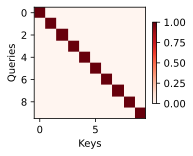

In [ ]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

##注意力汇聚：Nadaraya-Watson核回归

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

###生成数据集

根据非线性函数：\begin{equation} y_i = 2sin(x_i) + x_{i}^{0.8} + \xi \end{equation}
生成数据集

In [ ]:
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train)*5) # 排序后的训练样本

In [ ]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,)) # 训练样本的输出
x_test = torch.arange(0,5,0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数
n_test

50



*   训练样本（由圆圈表示）
*   不带噪声项的真实数据生成的函数f（标记为"Truth"）
*   学习得到的预测函数（标记为"Pred"）




In [ ]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test,[y_truth,y_hat],'x','y',legend=['Truth','Pred'],xlim=[0,5],ylim=[-1,5])
    d2l.plt.plot(x_train,y_train,'o',alpha=0.5)

###平均汇聚
平均汇聚的公式\begin{equation} f(x) = \frac{1}{n}Σ_{i=1}^{n}y_i\end{equation}

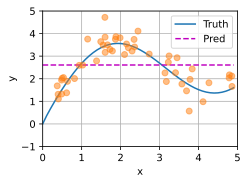

In [ ]:
y_hat = torch.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

###非参数注意力汇聚
由于平均汇聚忽略了输入，因此根据输入的位置对输出进行加权：
\begin{equation} f(x)=Σ_{i=1}^{n}\frac{K(x-x_i)}{Σ_{i=1}^{n}K(x-x_i)}y_i \end{equation}
经过改良，获得更通用的注意力汇聚公式：
\begin{equation} f(x)=Σ_{i=1}^{n}α(x,x_i)y_i \end{equation}
令高斯核为：
\begin{equation} K(u)=\frac{1}{\sqrt{2π}}exp(-\frac{u^2}{2}) \end{equation} 
将高斯核带入注意力汇聚公式：
\begin{equation} f(x)=Σ_{i=1}^{n}softmax(-\frac{1}{2}(x-x_i)^2)y_i \end{equation}
如果一个键越是接近给定的查询，那么分配给这个键对应值的注意力权重就会越大，也就是“获得了更多的注意力”

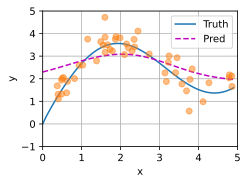

In [ ]:
# X_repeat的形状：（n_test,n_train）,
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1,n_train))
# x_train包含着键。attention_weights的形状：（n_test,n_train）,
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2 / 2,dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)


*   测试数据的输入相当于查询
*   训练数据的输入相当于键

“查询——键”对越接近，注意力汇聚的注意力权重越高



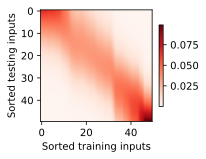

In [ ]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),xlabel='Sorted training inputs',ylabel='Sorted testing inputs')

###带参数注意力汇聚

\begin{equation} f(x)=Σ_{i=1}^{n}softmax(-\frac{1}{2}((x-x_i)\omega)^2)y_i \end{equation}

*   批量矩阵乘法

\begin{equation} (n,a,b),(n,b,c) \to (n,a,c) \end{equation}



In [ ]:
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

计算加权平均值

In [ ]:
weights = torch.ones((2,10)) * 0.1
values = torch.arange(20.0).reshape((2,10))
torch.bmm(weights.unsqueeze(1),values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

*   定义模型

In [ ]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True))

    def forward(self,queries,keys,values):
        # queries和attention_weights的形状为(查询个数，"键——值"对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 /2,dim=1)
        # values的形状为（查询个数，"键——值"对个数）
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)

*   训练

In [ ]:
# X_title的形状：（n_train，n_train），每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train,1))
# Y_title的形状：（n_train，n_train），每一行都包含着相同的训练输入
Y_tile = y_train.repeat((n_train,1))
# keys的形状：（'n_train'，'n_train'-1）
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
# values的形状：（'n_train'，'n_train'-1）
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

使用平方损失函数和随机梯度下降

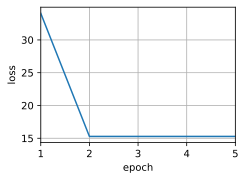

In [ ]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(),lr=0.5)
animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train,keys,values),y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch{epoch + 1}, loss{float(l.sum()):.6f}')
    animator.add(epoch + 1,float(l.sum()))

带噪声的数据训练结果不如非参数模型的平滑

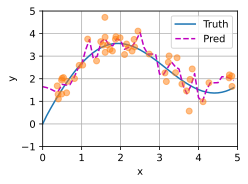

In [ ]:
# keys的形状：（n_test，n_train），每一行包含着相同的训练输入（eg.相同的键）
keys = x_train.repeat((n_test,1))
# value的形状：（n_test，n_train)
values = y_train.repeat((n_test,1))
y_hat = net(x_test,keys,values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

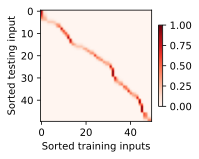

In [ ]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),xlabel='Sorted training inputs',ylabel='Sorted testing input')